Tokenized json1 object 1: ['type', 'intrusion', '##set', 'name', 'apt', 'intrusion', 'set', 'description', 'suspected', 'to', 'be', 'funded', 'by', 'fran', '##istan', 'file', 'j', '##son', '##1']
Embedding shape for json1 object 1: (1, 768)
Tokenized json1 object 2: ['type', 'software', 'name', 'word', 'processor', 'description', 'a', 'software', 'application', 'used', 'for', 'creating', 'and', 'editing', 'text', 'documents', 'file', 'j', '##son', '##1']
Embedding shape for json1 object 2: (1, 768)
Tokenized json1 object 3: ['type', 'device', 'name', 'smartphone', 'description', 'a', 'handheld', 'device', 'that', 'combines', 'mobile', 'phone', 'and', 'computing', 'functions', 'file', 'j', '##son', '##1']
Embedding shape for json1 object 3: (1, 768)
Tokenized json1 object 4: ['type', 'organization', 'name', 'tech', 'corp', 'description', 'a', 'company', 'specializing', 'in', 'technology', 'and', 'software', 'development', 'file', 'j', '##son', '##1']
Embedding shape for json1 object 4: 

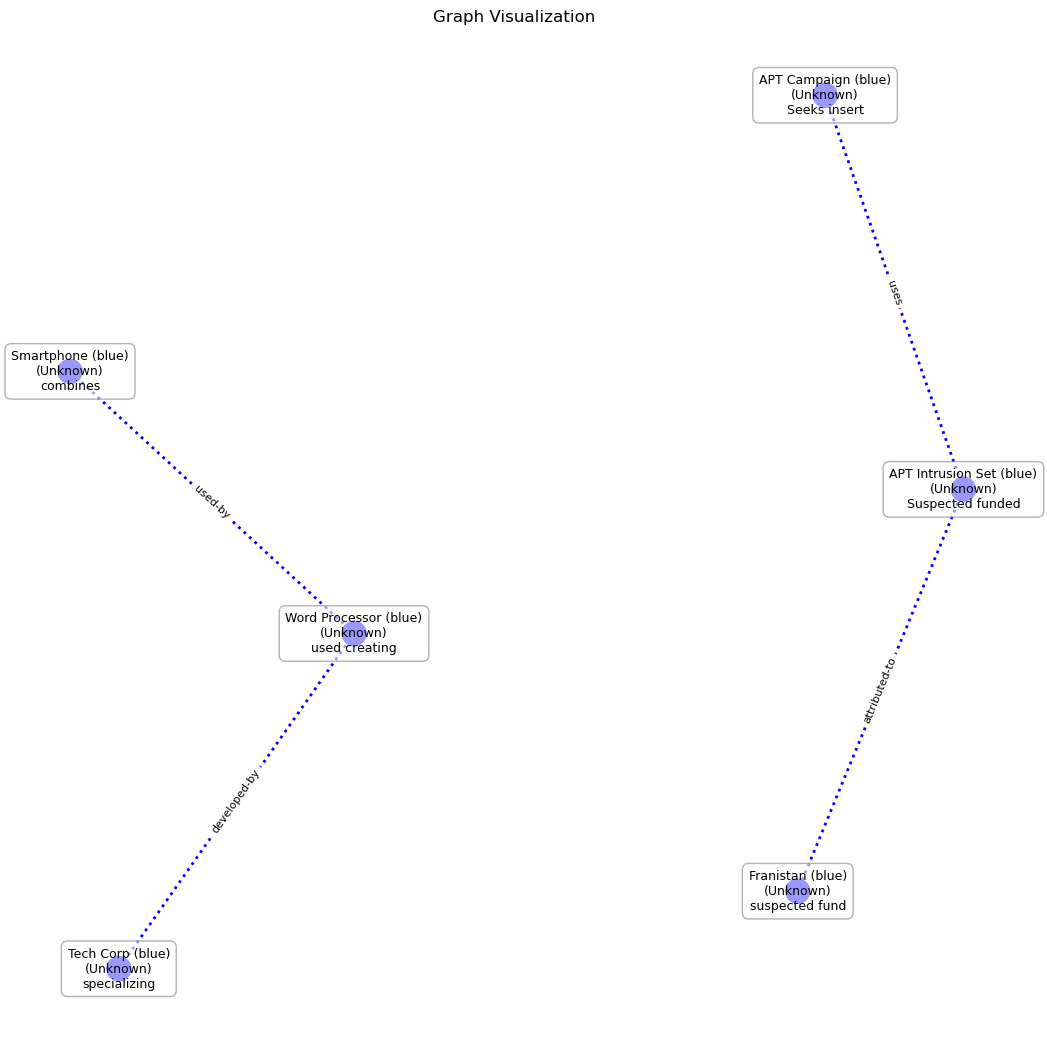

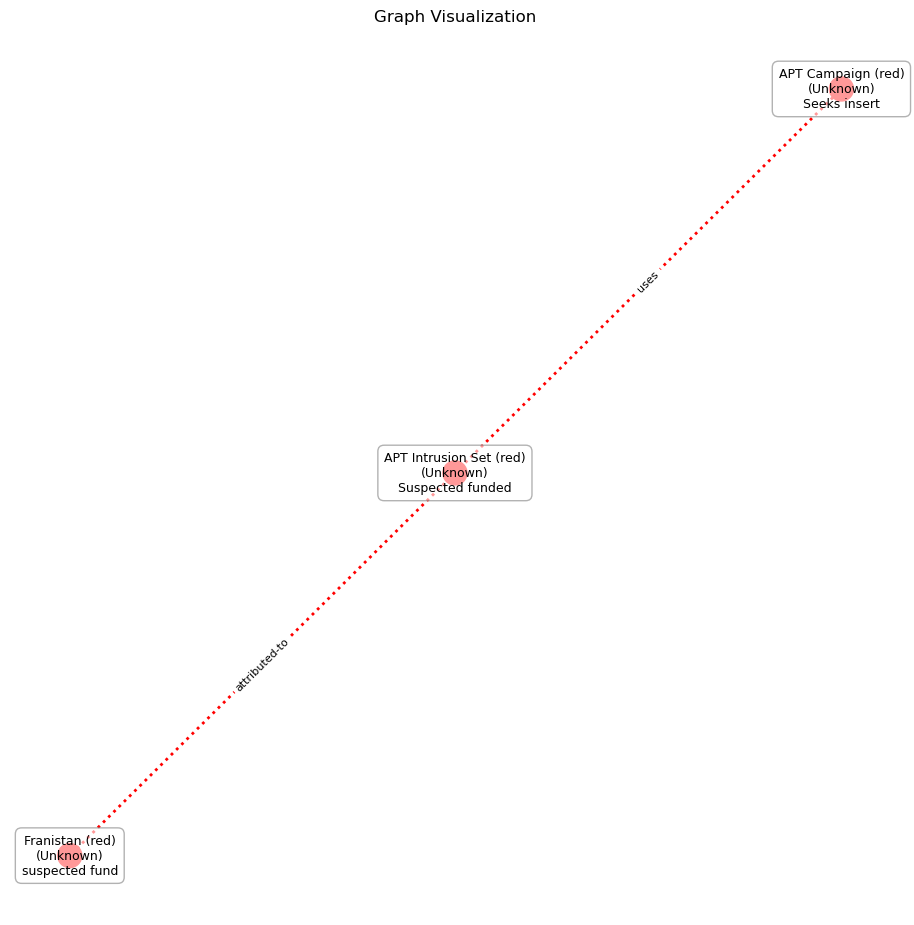

Node Distance (Simple): 5
Node Distance (Jaccard): 1.00
Key Distance (Simple): 0
Key Distance (Jaccard): 0.00
Value Distance (Simple): 11
Value Distance (Jaccard): 0.52
Graph Distance (Simple): 5
Graph Distance (Jaccard): 1.00


In [12]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from transformers import BertModel, BertTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import string
import pandas as pd
import spacy
import os

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Load the BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Create a new directory to save all files
output_dir = 'output_files'
os.makedirs(output_dir, exist_ok=True)

# Define global threshold variable
threshold = 0.8

def preprocess_text(text):
    """Preprocess text by lowercasing and removing punctuation."""
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    return text

def get_embeddings(text):
    """Get BERT embeddings for the given text."""
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Last hidden state (embedding)
    return outputs.last_hidden_state.mean(dim=1).numpy()

def save_tokenized_texts_combined(tokenized_texts, file_label):
    """Save combined tokenized texts to a file."""
    with open(os.path.join(output_dir, f"combined_tokenized_output_{file_label}.txt"), "w") as f:
        for tokenized_text in tokenized_texts:
            f.write(" ".join(tokenized_text) + "\n")

def save_embeddings_combined(embeddings, file_label):
    """Save combined embeddings as .npy file."""
    combined_embeddings = np.vstack(embeddings)
    np.save(os.path.join(output_dir, f"combined_embeddings_{file_label}.npy"), combined_embeddings)

def json_to_text(data, file_label):
    """Convert JSON entries to text for analysis and remove 'id' key. Add a 'file' key."""
    texts = []
    embeddings = []
    tokenized_texts = []
    json_objects = {}
    original_ids = {}
    labels = []
    for i, entry in enumerate(data):
        original_id = entry.pop('id', None)  # Remove 'id' key and store it
        if original_id:
            original_ids[original_id] = entry  # Map original 'id' to entry

        entry['file'] = file_label  # Add 'file' key
        entry_items = list(entry.items())  # Get all key-value pairs
        first_key_value = entry_items[0] if len(entry_items) > 0 else ("None", "None")
        second_key_value = entry_items[1] if len(entry_items) > 1 else ("None", "None")
        labels.append(f"{first_key_value[0]}: {first_key_value[1]} ({file_label}), {second_key_value[0]}: {second_key_value[1]} ({file_label})")
        text = ". ".join(f"{key}: {value}" if not isinstance(value, list) else f"{key}: " + ", ".join(map(str, value)) for key, value in entry.items())
        text = preprocess_text(text)
        texts.append(text)

        # Tokenization
        tokenized_text = tokenizer.tokenize(text)
        print(f"Tokenized {file_label} object {i + 1}: {tokenized_text}")
        tokenized_texts.append(tokenized_text)

        # Get and save embeddings
        embedding = get_embeddings(text)
        print(f"Embedding shape for {file_label} object {i + 1}: {embedding.shape}")
        embeddings.append(embedding)
        
        json_objects[text] = {'entry': entry, 'first_key_value': first_key_value, 'second_key_value': second_key_value}
    return texts, embeddings, tokenized_texts, json_objects, original_ids, labels

def load_json(file_path):
    """Load JSON data from a file with detailed error handling."""
    try:
        with open(file_path, 'r') as file:
            data = file.read()
            return json.loads(data)
    except FileNotFoundError:
        print(f"Error: File not found - {file_path}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error: Failed to decode JSON from file - {file_path}")
        print(f"Error details: {e}")
        print(f"Faulty JSON content:\n{data}")
        return None

def assign_encode_ids(texts1, embeddings1, texts2, embeddings2, json_objects1, json_objects2, original_ids1, original_ids2, threshold):

    """Assign encodeID to similar JSON objects in two datasets, ensuring cross-file matching and update source_ref/target_ref."""
    combined_texts = texts1 + texts2
    combined_embeddings = np.vstack(embeddings1 + embeddings2)
    combined_json_objects = {**json_objects1, **json_objects2}

    # Ensure all objects have 'first_key_value', 'second_key_value', and 'entry'
    for text in combined_texts:
        if text not in combined_json_objects:
            continue
        if 'first_key_value' not in combined_json_objects[text] or 'second_key_value' not in combined_json_objects[text] or 'entry' not in combined_json_objects[text]:
            print(f"Missing 'first_key_value', 'second_key_value' or 'entry' in combined_json_objects for text: {text}")
            print(combined_json_objects[text])
            continue

    # Compute similarity matrix for combined texts
    similarity_matrix = cosine_similarity(combined_embeddings)
    encode_id = 1
    unmatched_encode_id = 10000
    encode_id_mapping = {}
    assigned_encode_ids = set()

    # Create comparison matrix and identify matches
    num_texts = len(combined_texts)
    comparison_matrix = np.zeros((num_texts, num_texts))
    for i in range(num_texts):
        for j in range(num_texts):
            if i != j:
                similarity = similarity_matrix[i, j]
                comparison_matrix[i, j] = similarity
                if similarity > threshold and combined_json_objects[combined_texts[i]]['entry']['file'] != combined_json_objects[combined_texts[j]]['entry']['file']:
                    if combined_texts[i] not in assigned_encode_ids and combined_texts[j] not in assigned_encode_ids:
                        encode_id_mapping[combined_texts[i]] = encode_id
                        encode_id_mapping[combined_texts[j]] = encode_id
                        assigned_encode_ids.add(combined_texts[i])
                        assigned_encode_ids.add(combined_texts[j])
                        encode_id += 1

    for text in combined_texts:
        if text not in encode_id_mapping:
            encode_id_mapping[text] = unmatched_encode_id
            unmatched_encode_id += 1

    for text, obj in combined_json_objects.items():
        if text in encode_id_mapping:
            obj['entry']['encodeID'] = encode_id_mapping[text]

    json_objects1 = {text: obj['entry'] for text, obj in combined_json_objects.items() if obj['entry']['file'] == 'json1'}
    json_objects2 = {text: obj['entry'] for text, obj in combined_json_objects.items() if obj['entry']['file'] == 'json2'}

    # Create a dictionary to map original IDs to encodeIDs
    id_to_encodeID = {original_id: obj['encodeID'] for original_id, obj in original_ids1.items()}
    id_to_encodeID.update({original_id: obj['encodeID'] for original_id, obj in original_ids2.items()})

    # Update source_ref and target_ref in relationship objects
    for obj in json_objects1.values():
        if obj['type'] == 'relationship':
            obj['source_ref'] = id_to_encodeID.get(obj['source_ref'], obj['source_ref'])
            obj['target_ref'] = id_to_encodeID.get(obj['target_ref'], obj['target_ref'])

    for obj in json_objects2.values():
        if obj['type'] == 'relationship':
            obj['source_ref'] = id_to_encodeID.get(obj['source_ref'], obj['source_ref'])
            obj['target_ref'] = id_to_encodeID.get(obj['target_ref'], obj['target_ref'])

    return json_objects1, json_objects2, comparison_matrix, combined_embeddings

def save_json(data, file_path):
    """Save JSON data to a file."""
    with open(os.path.join(output_dir, file_path), 'w') as file:
        json.dump(list(data.values()), file, indent=4)

def build_graph(json_objects, suffix, color):
    """Build a graph based on JSON objects."""
    G = nx.Graph()
    valid_nodes = set()

    # Add nodes, ensuring unique IDs
    for key, obj in json_objects.items():
        if obj['type'] != 'relationship':  # Only add entities as nodes
            if obj.get('name') != 'Unknown Name':  # Avoid adding unknown name nodes
                unique_id = str(obj.get('encodeID')) + suffix
                node_name = f"{obj.get('name', 'Unknown Entity')} ({color})"
                G.add_node(unique_id, label=node_name, color=color,
                           description=obj.get('description', 'No description provided'))
                valid_nodes.add(unique_id)
        else:
            continue

    # Add edges, using unique IDs
    unique_edges = set()
    for obj in json_objects.values():
        if obj['type'] == 'relationship':
            source = str(obj.get('source_ref')) + suffix
            target = str(obj.get('target_ref')) + suffix
            edge = (source, target)
            if source in valid_nodes and target in valid_nodes and source != target:  # Ensure both nodes are valid and not the same
                if edge in unique_edges:
                    G[source][target]['style'] = 'solid'
                    G[source][target]['color'] = 'black'
                else:
                    G.add_edge(source, target, style='dotted', color=color, label=obj.get('relationship_type', 'similar-to'))
                    unique_edges.add(edge)
    return G

def visualize_graph(G):
    """Visualize a networkx graph with enhanced label formatting for readability."""
    num_nodes = len(G.nodes)
    figsize = get_optimal_figsize(num_nodes)
    k = get_optimal_k(num_nodes)

    plt.figure(figsize=figsize)  # Dynamically set figure size
    pos = nx.spring_layout(G, k=k)  # Dynamically set layout parameter

    # Draw nodes with their corresponding colors
    node_colors = [data.get('color', 'grey') for node, data in G.nodes(data=True)]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300)

    # Draw edges with specified styles and colors
    for (u, v, data) in G.edges(data=True):
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)],
            style=data.get('style', 'dotted' if data['color'] == 'gray' else 'solid'),
            edge_color=data.get('color', 'black'),
            width=2
        )

    # Draw edge labels
    edge_labels = {(u, v): data.get('label', 'similar-to') for u, v, data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Draw labels for nodes
    labels = {}
    for node, data in G.nodes(data=True):
        label = f"{data.get('label', 'Unknown')}\n({data.get('type', 'Unknown')})"
        description = data.get('description', 'No description provided')
        if description:
            doc = nlp(description)
            verbs = [token.text for token in doc if token.pos_ == 'VERB']
            label += f"\n{' '.join(verbs[:2])}"
        labels[node] = label

    for node, label in labels.items():
        x, y = pos[node]
        plt.text(x, y, label, fontsize=9, ha='center', va='center',
                 bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='gray', alpha=0.6))

    plt.title('Graph Visualization')
    plt.axis('off')
    plt.show()

def get_optimal_figsize(num_nodes):
    """Determine an optimal figure size based on the number of nodes."""
    base_size = 10  # Base size for the figure
    scale_factor = 0.5  # Scale factor to adjust size
    return (base_size + num_nodes * scale_factor, base_size + num_nodes * scale_factor)

def get_optimal_k(num_nodes):
    """Determine an optimal k value for spring_layout based on the number of nodes."""
    base_k = 0.5  # Base k value
    scale_factor = 0.1  # Scale factor to adjust k
    return base_k + num_nodes * scale_factor

def calculate_distances(json_objects1, json_objects2):
    """Calculate node distance, key distance, value distance, and graph distance."""
    def jaccard_distance(set1, set2):
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return 1 - intersection / union if union != 0 else 1

    def set_distance(set1, set2):
        return abs(len(set1) - len(set2))

    # Node distance
    nodes1 = set(json_objects1.keys())
    nodes2 = set(json_objects2.keys())
    node_distance = set_distance(nodes1, nodes2)
    node_jaccard = jaccard_distance(nodes1, nodes2)

    # Key distance
    keys1 = set(k for obj in json_objects1.values() for k in obj.keys())
    keys2 = set(k for obj in json_objects2.values() for k in obj.keys())
    key_distance = set_distance(keys1, keys2)
    key_jaccard = jaccard_distance(keys1, keys2)

    # Value distance
    values1 = set(v for obj in json_objects1.values() for v in obj.values() if isinstance(v, str))
    values2 = set(v for obj in json_objects2.values() for v in obj.values() if isinstance(v, str))
    value_distance = set_distance(values1, values2)
    value_jaccard = jaccard_distance(values1, values2)

    # Graph distance (using node and edge comparison)
    G1 = build_graph(json_objects1, '_blue', 'blue')
    G2 = build_graph(json_objects2, '_red', 'red')
    graph_distance = abs(G1.number_of_nodes() - G2.number_of_nodes()) + abs(G1.number_of_edges() - G2.number_of_edges())
    graph_jaccard = jaccard_distance(set(G1.edges()), set(G2.edges()))

    print(f"Node Distance (Simple): {node_distance}")
    print(f"Node Distance (Jaccard): {node_jaccard:.2f}")
    print(f"Key Distance (Simple): {key_distance}")
    print(f"Key Distance (Jaccard): {key_jaccard:.2f}")
    print(f"Value Distance (Simple): {value_distance}")
    print(f"Value Distance (Jaccard): {value_jaccard:.2f}")
    print(f"Graph Distance (Simple): {graph_distance}")
    print(f"Graph Distance (Jaccard): {graph_jaccard:.2f}")

def create_comparison_matrix(texts1, embeddings1, texts2, embeddings2, json_objects1, json_objects2, threshold):

    """Create a comparison matrix and identify matches."""
    combined_texts = texts1 + texts2
    combined_embeddings = np.vstack(embeddings1 + embeddings2)
    combined_json_objects = {**json_objects1, **json_objects2}

    # Compute similarity matrix for combined texts
    similarity_matrix = cosine_similarity(combined_embeddings)

    # Debugging: Print combined_json_objects to identify missing keys
    for text, json_objects in combined_json_objects.items():
        if 'first_key_value' not in json_objects or 'entry' not in json_objects:
            print(f"Missing key in combined_json_objects for text: {text}")
            print(json_objects)

    # Create comparison matrix and identify matches
    num_texts = len(combined_texts)
    comparison_data = []
    for i in range(num_texts):
        row = []
        for j in range(num_texts):
            if i == j:
                row.append('X')
            else:
                similarity = similarity_matrix[i, j]
                match = 1 if similarity > threshold else 0
                row.append(match)
        comparison_data.append(row)

    # Create DataFrame for comparison matrix
    labels = []
    for text, json_objects in combined_json_objects.items():
        if 'first_key_value' in json_objects and 'entry' in json_objects:
            labels.append(f"{json_objects['first_key_value'][0]}: {json_objects['first_key_value'][1]} ({json_objects['entry']['file']}), {json_objects['second_key_value'][0]}: {json_objects['second_key_value'][1]} ({json_objects['entry']['file']})")
        else:
            labels.append("Unknown: Unknown (Unknown)")  # Fallback for missing keys

    comparison_df = pd.DataFrame(comparison_data, index=labels, columns=labels)

    return comparison_df, similarity_matrix

def save_comparison_matrix_to_excel(comparison_df, similarity_matrix, file_path):
    """Save the comparison matrix and similarity values to an Excel file."""
    with pd.ExcelWriter(os.path.join(output_dir, file_path)) as writer:
        comparison_df.to_excel(writer, sheet_name='Comparison Matrix')

        # Add similarity values sheet
        similarity_df = pd.DataFrame(similarity_matrix, index=comparison_df.index, columns=comparison_df.columns)
        similarity_df.to_excel(writer, sheet_name='Similarity Values')

def save_embeddings_to_excel(embeddings, labels, file_path, threshold):
    """Save aggregated embeddings and similarity matrix to an Excel file."""
    
    # Aggregate embeddings
    aggregated_embeddings = np.array([embedding.mean(axis=0) for embedding in embeddings])
    
    # Create a DataFrame for aggregated embeddings
    embeddings_df = pd.DataFrame(aggregated_embeddings, index=labels)
    
    # Compute similarity matrix
    similarity_matrix = cosine_similarity(aggregated_embeddings)
    
    # Create binary match matrix
    match_matrix = np.where(similarity_matrix > threshold, 1, 0).astype(float)  # Ensure float array
    np.fill_diagonal(match_matrix, np.nan)  # Use np.nan instead of None
    
    # Create DataFrames for similarity and match matrices
    similarity_df = pd.DataFrame(similarity_matrix, index=labels, columns=labels)
    match_df = pd.DataFrame(match_matrix, index=labels, columns=labels)
    
    # Save to Excel
    with pd.ExcelWriter(os.path.join(output_dir, file_path)) as writer:
        embeddings_df.to_excel(writer, sheet_name='Aggregated Embeddings')
        similarity_df.to_excel(writer, sheet_name='Similarity Matrix')
        match_df.to_excel(writer, sheet_name='Match Matrix')

def main():
    global threshold  # Declare threshold as global to modify it within the function
    path1 = input("Enter the file path for JSON 1: ").strip('"')
    path2 = input("Enter the file path for JSON 2: ").strip('"')
        
    # Dynamic threshold based on user input or default
    threshold = float(input("Enter the similarity threshold (e.g., 0.8): ").strip())

    data1 = load_json(path1)
    if data1 is None:
        return

    data2 = load_json(path2)
    if data2 is None:
        return

    texts1, embeddings1, tokenized_texts1, json_objects1, original_ids1, labels1 = json_to_text(data1, 'json1')
    texts2, embeddings2, tokenized_texts2, json_objects2, original_ids2, labels2 = json_to_text(data2, 'json2')

    combined_labels = labels1 + labels2
    combined_embeddings = embeddings1 + embeddings2
    combined_tokenized_texts = tokenized_texts1 + tokenized_texts2

    # Save combined tokenized texts and embeddings
    save_tokenized_texts_combined(combined_tokenized_texts, 'combined')
    save_embeddings_combined(combined_embeddings, 'combined')

    # Save embeddings and similarity matrix to an Excel file
    save_embeddings_to_excel(combined_embeddings, combined_labels, 'embeddings_and_similarity.xlsx', threshold)


    json_objects1, json_objects2, comparison_matrix, combined_embeddings = assign_encode_ids(texts1, embeddings1, texts2, embeddings2, json_objects1, json_objects2, original_ids1, original_ids2, threshold)

    # Save normalized JSON data to files for evaluation
    save_json(json_objects1, 'normalized_data1.json')
    save_json(json_objects2, 'normalized_data2.json')

    # Create and save comparison matrix to Excel
    combined_labels = labels1 + labels2
    comparison_df, similarity_matrix = create_comparison_matrix(texts1, embeddings1, texts2, embeddings2, json_objects1, json_objects2, threshold)
    comparison_df.index = combined_labels
    comparison_df.columns = combined_labels
    save_comparison_matrix_to_excel(comparison_df, similarity_matrix, 'comparison_matrix.xlsx')

    print("Comparison matrix saved to 'output_files/comparison_matrix.xlsx'.")

    # Print detailed embedding information
    print("Embedding Details:")
    for i, text in enumerate(texts1 + texts2):
        print(f"Text {i + 1}: {text}")
        print(f"Embedding: {combined_embeddings[i]}")
        print(f"Dimensions: {combined_embeddings[i].shape}")

    # Build separate graphs for each JSON dataset
    G1 = build_graph(json_objects1, '_blue', 'blue')
    G2 = build_graph(json_objects2, '_red', 'red')

    visualize_graph(G1)
    visualize_graph(G2)

    # Calculate and print distances
    calculate_distances(json_objects1, json_objects2)

if __name__ == "__main__":
    main()